# Read in images

In [2]:
import pandas as pd

In [3]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id =  '20231001-091214_7dcfe07040dc26911af49b4388eec6e1'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [4]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [8]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

# Model building

In [10]:
# In this course, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers


def build_model(encoder_width: int, learning_rate_log: float) -> tf.keras.Model:
   
    mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # In other words, you will probably need to tweak these lines of code.
    
    layers = [
        # Encoder
        Dense(
            units=512, 
            activation='gelu', 
            input_shape=(28 * 28,)
        ),
        
        # Additional layers
        Dense(units=256, activation='gelu'),
        Dense(units=128, activation='gelu'),
        Dense(units=64, activation='gelu'),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (dark) and 1 (bright).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            learning_rate=10 ** learning_rate_log
        ), 
        loss='mean_squared_error',
    )
    return autoencoder

In [11]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

# Model training

In [13]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.
from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_denoise_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X),
        callbacks=[MlflowCallback()],
        verbose=verbose
    )
    
    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [14]:
# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
mlflow.set_experiment('assignment_01')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [15]:
mlflow.get_experiment_by_name('assignment_01')

<Experiment: artifact_location='file:///app/mlflow/325613237481706167', creation_time=1696285871101, experiment_id='325613237481706167', last_update_time=1696285871101, lifecycle_stage='active', name='assignment_01', tags={}>

In [16]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

with mlflow.start_run():
    autoencoder = build_model(encoder_width=10, learning_rate_log=0)
    history = train_denoise_model(autoencoder, epochs=20)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [17]:
train_actual_X = train_clean_X
train_reconstructed_X = autoencoder.predict(train_actual_X)
train_reconstruction_loss = ((train_actual_X - train_reconstructed_X) ** 2).sum(axis=1)
train_reconstruction_loss.shape

(49000,)

In [18]:
train_reconstruction_loss.mean()

95.80847

In [19]:
from sklearn.metrics import mean_squared_error

mean_squared_error(train_actual_X, train_reconstructed_X)

0.122203454

In [19]:
# train_stack_y_hat = (train_reconstruction_loss > train_reconstruction_loss.mean())
# (train_stack_y == train_stack_y_hat).mean() # model accuracy

## Run through different hyperparameters

In [20]:
# Random search
import random
import tqdm

runs = 15
learning_rate_logs = [random.uniform(-5, 0) for _ in range(runs)]
encoder_widths = [random.choice(range(5, 20, 5)) for _ in range(runs)]
parameters = list(zip(learning_rate_logs, encoder_widths))

for (learning_rate_log, encoder_width) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        autoencoder = build_model(encoder_width=encoder_width, learning_rate_log=learning_rate_log)
        history = train_denoise_model(autoencoder, epochs=20, verbose=0)

100%|██████████| 15/15 [21:14<00:00, 84.96s/it]


In [67]:
# Grid search
# from keras.wrappers.scikit_learn import KerasClassifier 
# from sklearn.model_selection import GridSearchCV

# with mlflow.start_run():
#     autoencoder = KerasClassifier(build_fn=build_model)
    
#     params={'encoder_width': [5, 10, 15, 20, 25, 30], 
#             'learning_rate_log': [-5, -4, -3, -2, -1, -0.5]}
    
#     gs = GridSearchCV(estimator = autoencoder, param_grid=params, cv=5)

#     gs = train_denoise_model(gs, epochs=20, verbose=0)

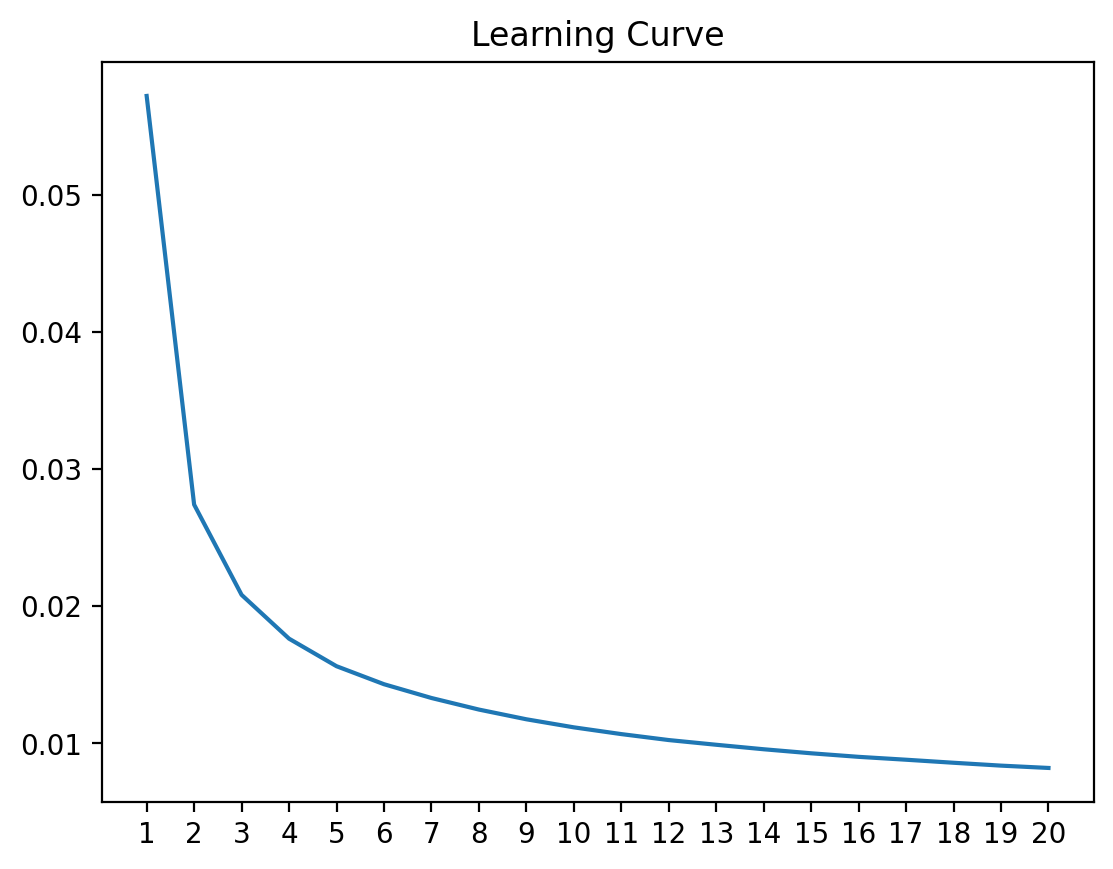

In [21]:
# The fit method returns a history object that
# can be used to plot the learning curve.

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

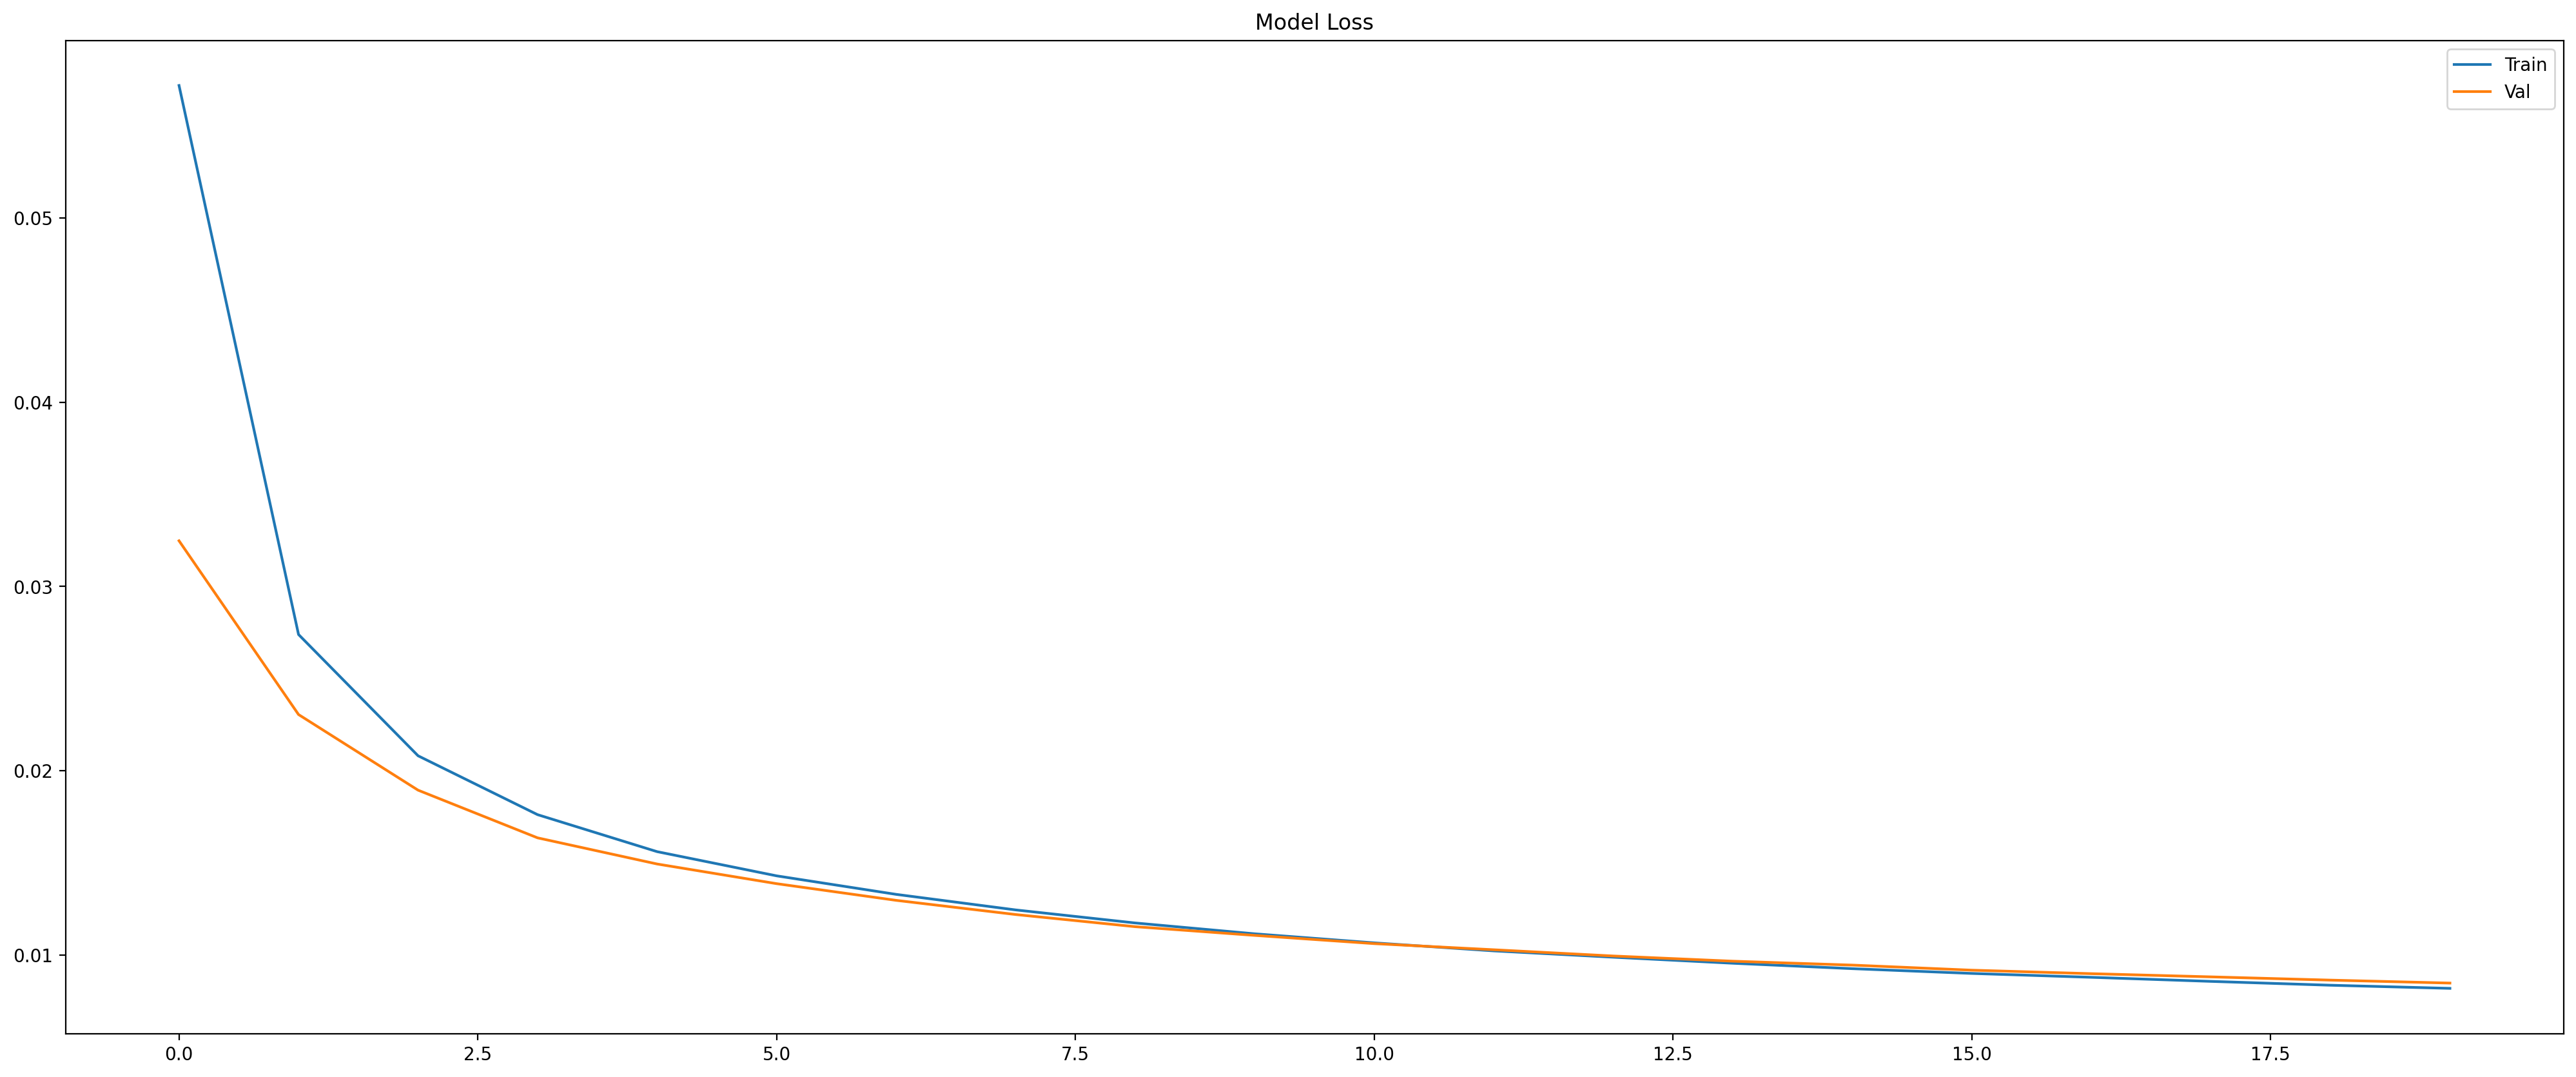

In [22]:
def plot_loss(history, x = 'loss', y = 'val_loss'): 
    fig, ax = plt.subplots( figsize=(25,10)) 
    ax.plot(history.history[x]) 
    ax.plot(history.history[y]) 
    plt.title('Model Loss') 
    plt.legend(['Train', 'Val'], loc='upper right') 
    plt.show()
    
plot_loss(history)

In [204]:
# This loads the last active run,
# but you probably want to load the best run from the experiment.
last_run = mlflow.last_active_run()
print(last_run.info.run_id)

7eb703f04a6845b68ea65036f77a97af


# Model evaluation

MLFlow was used to inspect training and validation losses, and then the best model was called to see test losses.

In [53]:
saved_model_path = mlflow.tracking.MlflowClient().download_artifacts("c2439c0fd29b477a818449c1d1ee152c", 'model') 
autoencoder = load_model(saved_model_path)

In [54]:
autoencoder.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 512)               401920    
                                                                 
 dense_66 (Dense)            (None, 256)               131328    
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dense_68 (Dense)            (None, 64)                8256      
                                                                 
 dense_69 (Dense)            (None, 784)               50960     
                                                                 
Total params: 625,360
Trainable params: 625,360
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Now we can feed the noisy images into the autoencoder.
test_denoised_X = autoencoder.predict(test_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
test_denoised_X = pd.DataFrame(test_denoised_X)

In [56]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_denoised_X, test_clean_X)

0.0072205956

In [57]:
print(test_clean_X.index)
print(test_denoised_X.index)

RangeIndex(start=0, stop=7000, step=1)
RangeIndex(start=0, stop=7000, step=1)


In [58]:
print(test_clean_X.columns)
print(test_denoised_X.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '774', '775', '776', '777', '778', '779', '780', '781', '782', '783'],
      dtype='object', length=784)
RangeIndex(start=0, stop=784, step=1)


In [59]:
new_cols = []
for i in range(0, 784):
    new_cols.append(str(i))
#print(new_cols)

In [60]:
test_denoised_X.columns = new_cols

In [61]:
print(test_clean_X.columns)
print(test_denoised_X.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '774', '775', '776', '777', '778', '779', '780', '781', '782', '783'],
      dtype='object', length=784)
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '774', '775', '776', '777', '778', '779', '780', '781', '782', '783'],
      dtype='object', length=784)


In [62]:
test_reconstruction_loss = ((test_clean_X - test_denoised_X) ** 2).sum(axis=0)
print(test_reconstruction_loss.mean()/7000)

from sklearn.metrics import mean_squared_error

print(mean_squared_error(test_clean_X, test_denoised_X))

0.007220619201660157
0.0072205956


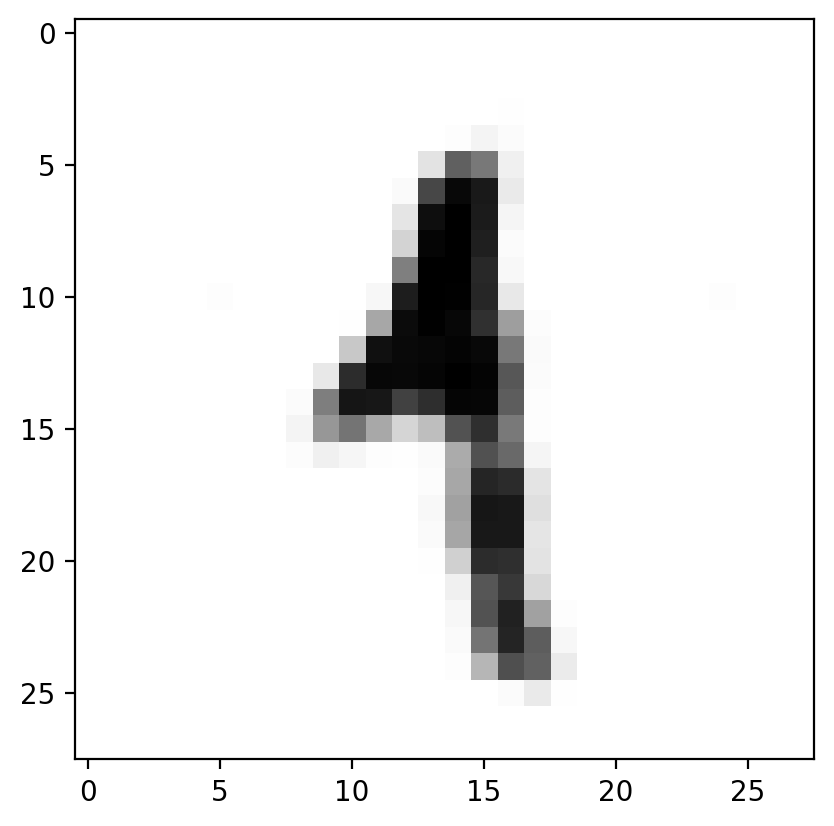

In [63]:
# Let's confirm that the denoiser works.
example_id = 100
image_pixels = test_denoised_X.iloc[example_id]
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

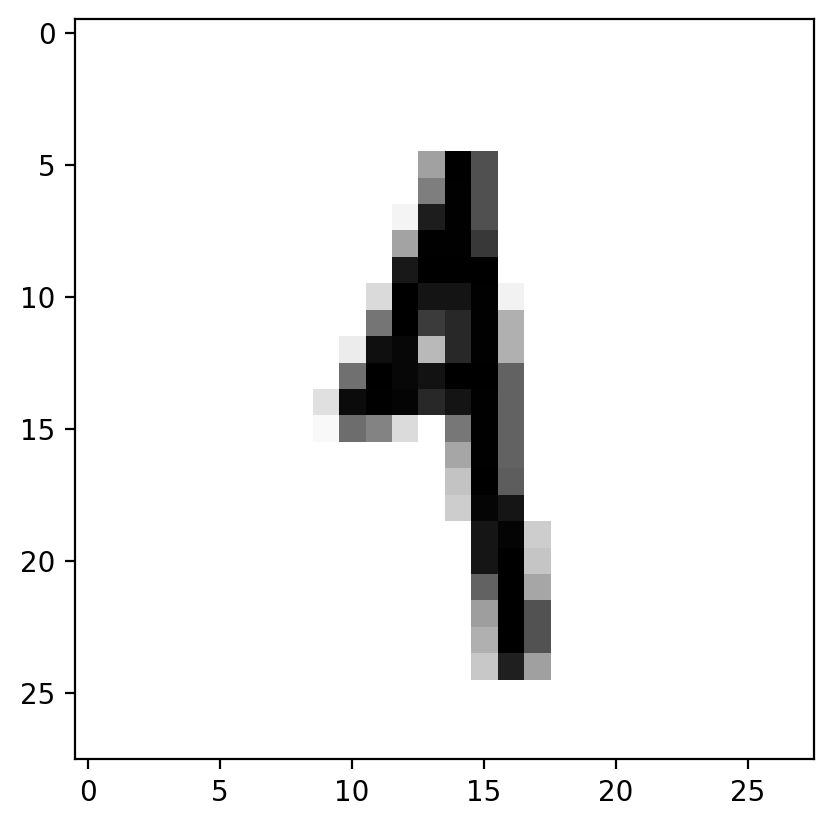

In [64]:
# Let's confirm that the denoiser works.
image_pixels = test_clean_X.iloc[example_id]
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

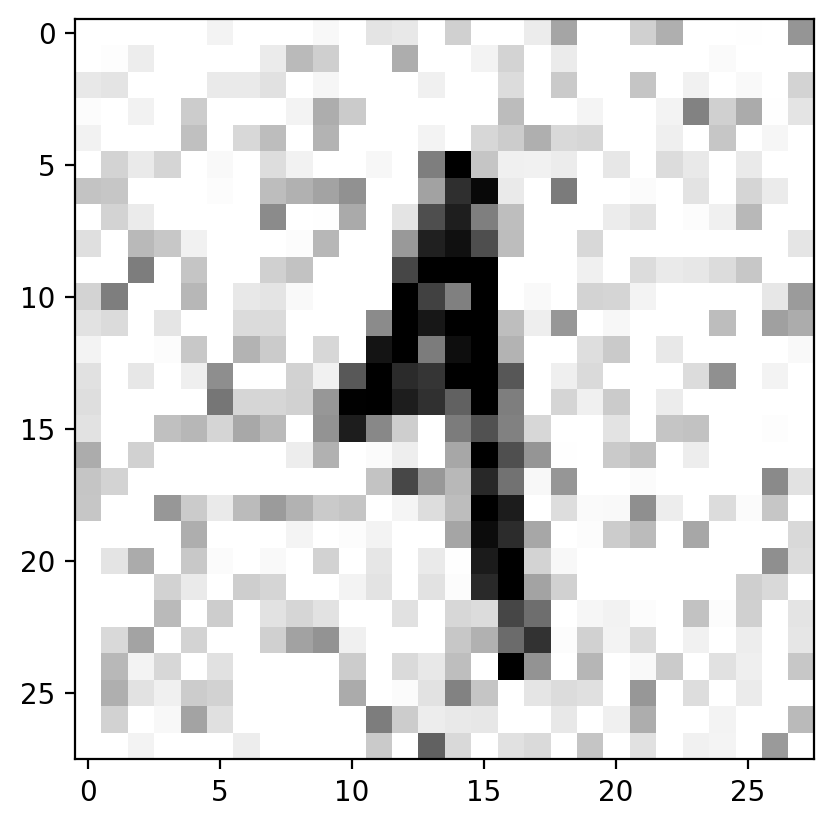

In [65]:
# Let's confirm that the denoiser works.
image_pixels = test_noisy_X.iloc[example_id]
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [66]:
import os 

model_path = 'assignment_submission'

os.makedirs(model_path, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_path}/score_denoised_x.parquet')

save_model(autoencoder, model_path)

# You now have the following files to be uploaded:
# 1. This notebook and any other Python code you used to train the final model.
# 2. architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset

In [ ]:
# EOF